# Uncertainty estimation

> [Strong random forests with XGBoost](https://www.r-bloggers.com/2021/05/strong-random-forests-with-xgboost/)

Author: https://github.com/deburky

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from rfgboost import RFGBoost

%config InlineBackend.figure_format = 'retina'

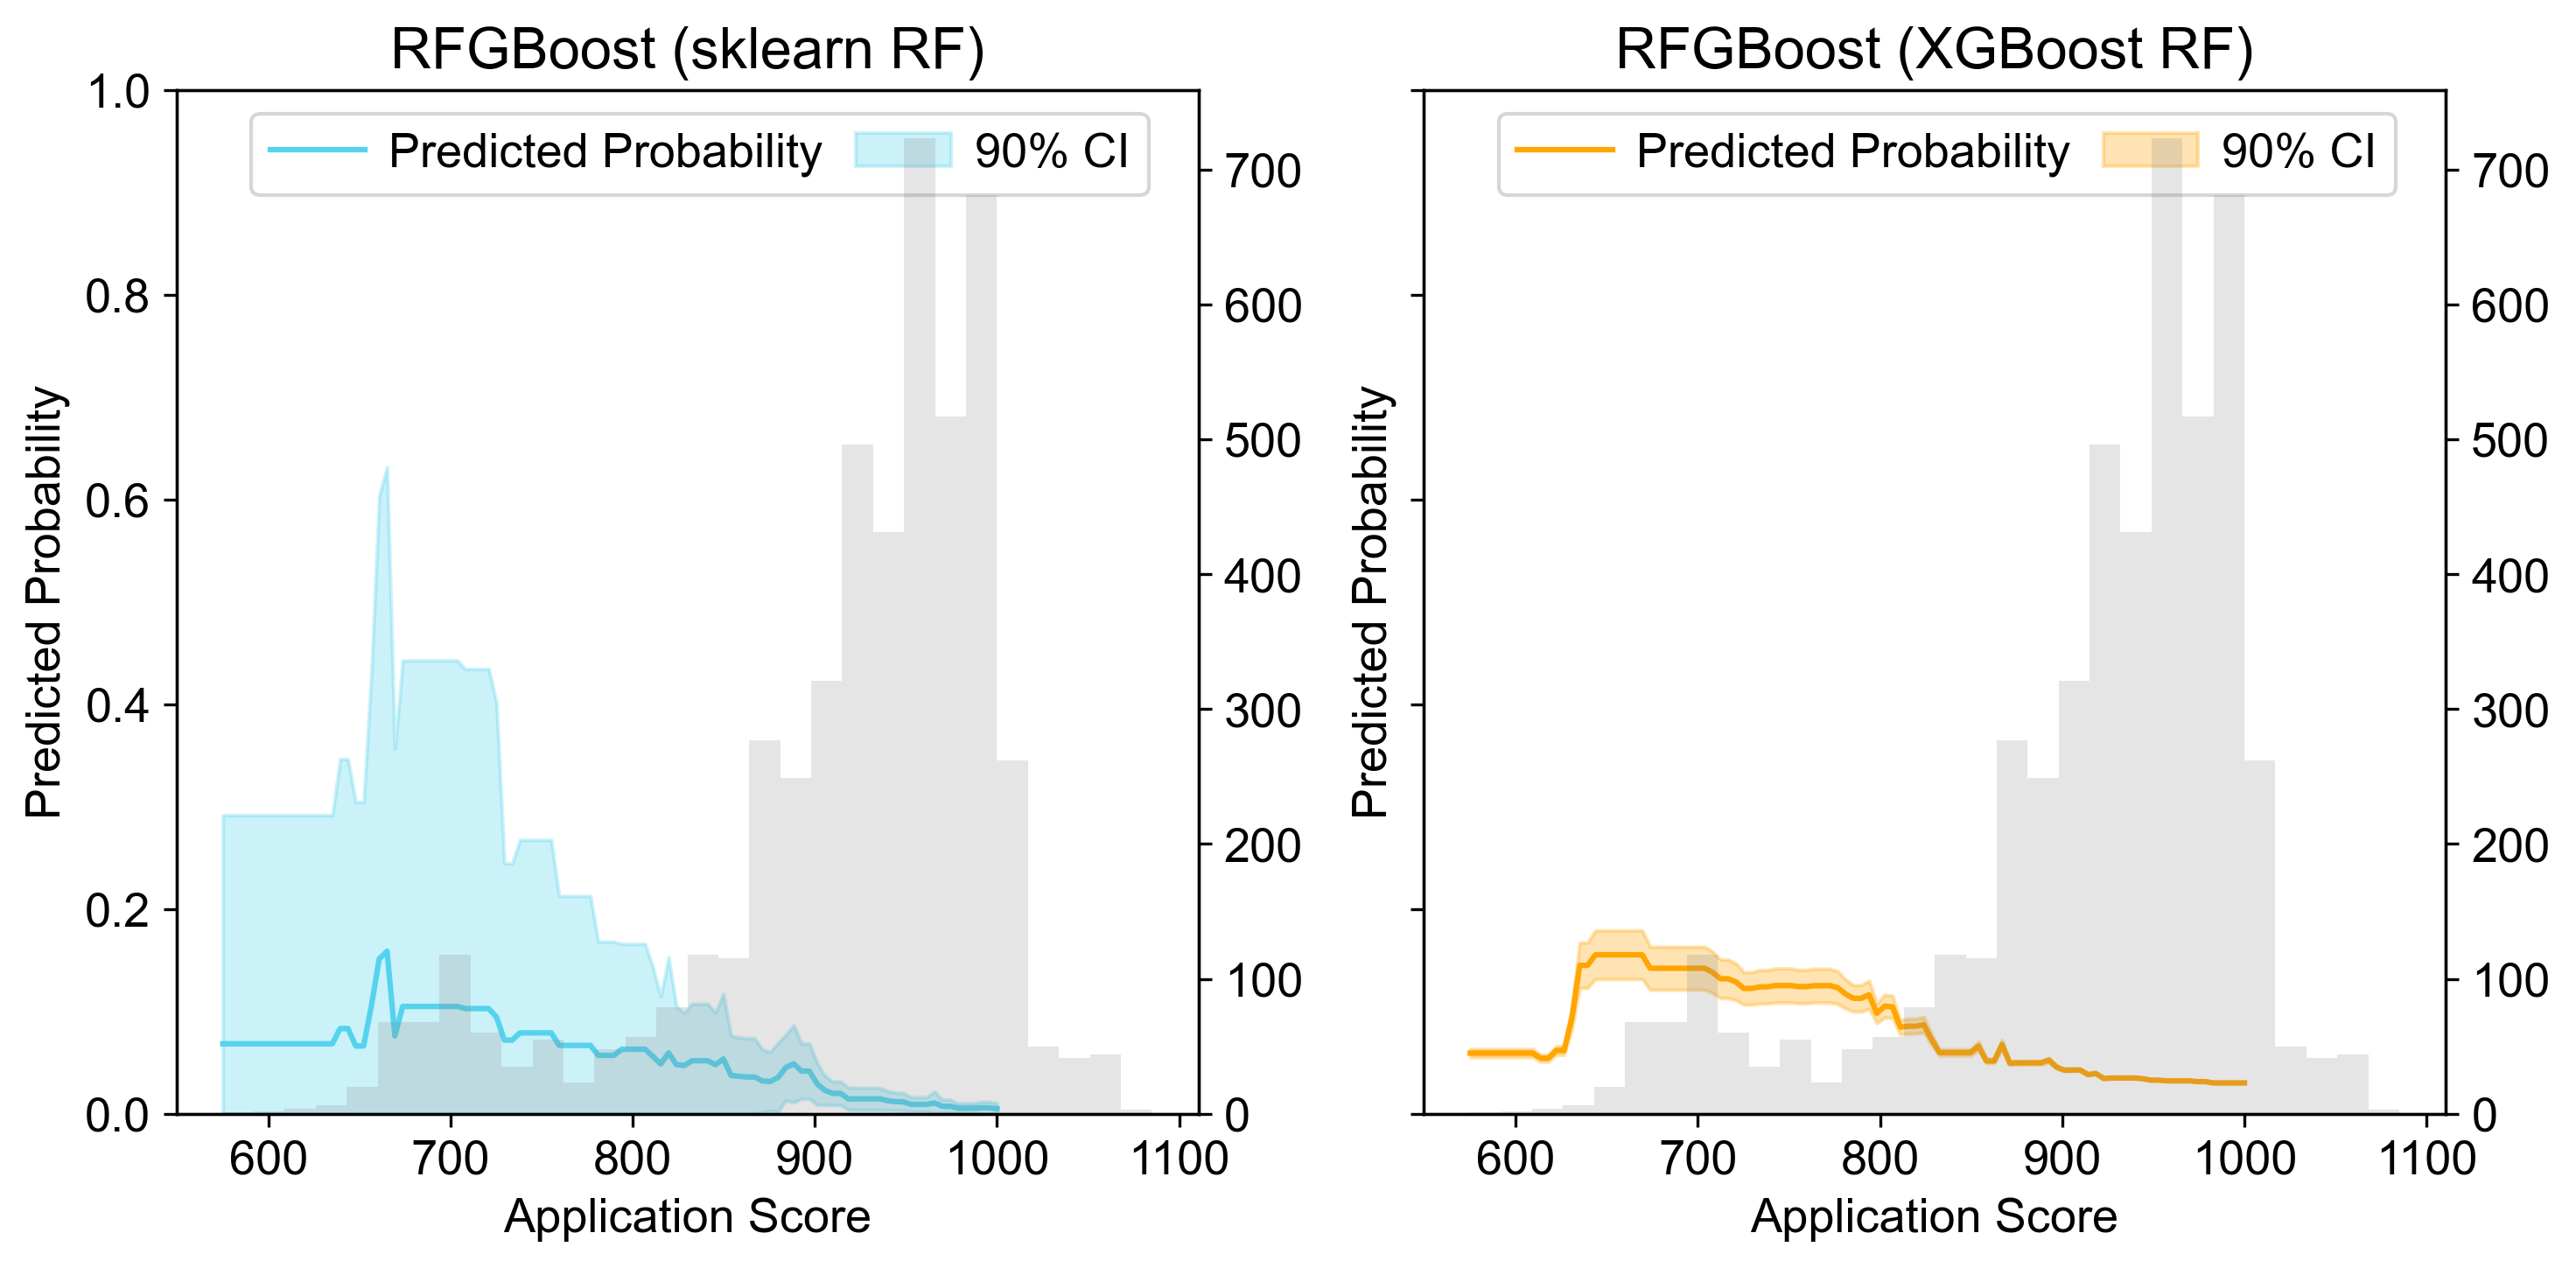

In [ ]:
# Set font to Arial
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 13

# Load dataset
ROOT_DIR = Path.cwd().parent
dataset = pd.read_csv(ROOT_DIR / "data" / "BankCaseStudyData.csv")
label = "Final_Decision"
dataset[label] = dataset[label].map({"Accept": 0, "Decline": 1})

features = ["Application_Score", "Bureau_Score"]
ix_train = dataset["split"] == "Development"
ix_test = dataset["split"] == "Validation"

X_train = dataset.loc[ix_train, features]
y_train = dataset.loc[ix_train, label]
X_test = dataset.loc[ix_test, features]
y_test = dataset.loc[ix_test, label]

# Model config
rf_params = {"n_estimators": 10, "max_depth": 4, "random_state": 0}

# Create both models
rfgb_model_sk = RFGBoost(
    n_estimators=10,
    rf_params=rf_params,
    learning_rate=0.5,
    task="classification",
    base_learner="sklearn",
)

rfgb_model_xgb = RFGBoost(
    n_estimators=10,
    rf_params=rf_params,
    learning_rate=0.5,
    task="classification",
    base_learner="xgboost",
)

# Fit both models
rfgb_model_sk.fit(X_train, y_train)
rfgb_model_xgb.fit(X_train, y_train)

# Fixed values for simulation
feature_range = (X_test["Application_Score"].min(), 1000)
fixed_values = {"Bureau_Score": X_test["Bureau_Score"].median()}


# Simulation function
def simulate_feature_effect(model, fixed_values, feature, value_range, num_points=100):
    values = np.linspace(value_range[0], value_range[1], num_points)
    df = pd.DataFrame({feature: values})
    for k, v in fixed_values.items():
        df[k] = v
    proba = model.predict_proba(df)[:, 1]
    ci = model.predict_ci(df, alpha=0.1)
    df["Predicted Proba"] = proba
    df["Lower CI"] = ci[:, 0]
    df["Upper CI"] = ci[:, 1]
    return df


# Simulate for both
df_sk = simulate_feature_effect(
    rfgb_model_sk, fixed_values, "Application_Score", feature_range
)
df_xgb = simulate_feature_effect(
    rfgb_model_xgb, fixed_values, "Application_Score", feature_range
)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=True)

for ax, df_sim, title in zip(
    axs,
    [df_sk, df_xgb],
    ["RFGBoost (sklearn RF)", "RFGBoost (XGBoost RF)"],
    strict=False,
):
    color = "#55d3ed" if title == "RFGBoost (sklearn RF)" else "#FFA500"
    ax.plot(
        df_sim["Application_Score"],
        df_sim["Predicted Proba"],
        label="Predicted Probability",
        color=color,
    )
    ax.fill_between(
        df_sim["Application_Score"],
        df_sim["Lower CI"],
        df_sim["Upper CI"],
        color=color,
        alpha=0.3,
        label="90% CI",
    )
    ax2 = ax.twinx()
    ax2.hist(X_test["Application_Score"], bins=30, alpha=0.2, color="gray")
    ax.set_title(title)
    ax.set_xlabel("Application Score")
    ax.set_ylabel("Predicted Probability")
    ax.set_ylim(0, 1)
    ax.legend(
        bbox_to_anchor=(0.05, 1),
        loc="upper left",
        ncols=2,
        handletextpad=0.5,
        columnspacing=0.7,
    )

axs[0].set_ylabel("Predicted Probability")
plt.tight_layout()
plt.show()